In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [2]:
# Spark session
spark = SparkSession \
        .builder \
        .appName("Analyze TV Shows Popularity") \
        .getOrCreate()

In [3]:
# Paths for analytics tables
dir_data = os.path.join(os.path.dirname(os.getcwd()), 'data')
path_tvshow = os.path.join(dir_data, 'tvshows.csv')
path_tweet_stat = os.path.join(dir_data, 'tweet_stat')
path_tmdb_stat = os.path.join(dir_data, 'tmdb_stat')

In [4]:
# TV shows table
schema_tvshow = StructType([StructField('id', IntegerType(), True),
                            StructField('name', StringType(), True),
                            StructField('origin_name', StringType(), True),
                            StructField('original_language', StringType(), True),
                            StructField('genres_id', StringType(), True),
                            StructField('networks_id', StringType(), True)])

tvshow = spark.read.csv(path_tvshow, header=True, schema = schema_tvshow)
tvshow.createOrReplaceTempView("tvshow")
tvshow.show(5)

+-----+--------------------+--------------------+-----------------+------------------+-----------+
|   id|                name|         origin_name|original_language|         genres_id|networks_id|
+-----+--------------------+--------------------+-----------------+------------------+-----------+
|71712|     The Good Doctor|     The Good Doctor|               en|              [18]|        [2]|
|82856|     The Mandalorian|     The Mandalorian|               en|[10765, 10759, 37]|     [2739]|
|62286|Fear the Walking ...|Fear the Walking ...|               en|       [10759, 18]|      [174]|
|87739|  The Queen's Gambit|  The Queen's Gambit|               en|              [18]|      [213]|
|94305|The Walking Dead:...|The Walking Dead:...|               en| [18, 10765, 9648]|      [174]|
+-----+--------------------+--------------------+-----------------+------------------+-----------+
only showing top 5 rows



In [5]:
# Tweet stat table
tweet_stat = spark.read.parquet(path_tweet_stat)
tweet_stat.createOrReplaceTempView("tweet_stat")
tweet_stat.show(5)

+------+-------------+----------+-----------+----------+----+-----+---+
|    id|hashtag_count|text_count|tweet_count|      date|year|month|day|
+------+-------------+----------+-----------+----------+----+-----+---+
|109958|           13|        50|         62|2020-11-23|2020|   11| 23|
|  1403|           18|         1|         18|2020-11-23|2020|   11| 23|
|  1412|           27|         0|         27|2020-11-23|2020|   11| 23|
|  1420|            3|       384|        386|2020-11-23|2020|   11| 23|
|  2316|           54|         0|         54|2020-11-23|2020|   11| 23|
+------+-------------+----------+-----------+----------+----+-----+---+
only showing top 5 rows



In [6]:
# TMDB stat table
tmdb_stat = spark.read.parquet(path_tmdb_stat)
tmdb_stat.createOrReplaceTempView("tmdb_stat")
tmdb_stat.show(5)

+-----+----------+------------+----------+------------------+-----------------+----------+----+-----+---+
|   id|popularity|vote_average|vote_count|number_of_episodes|number_of_seasons|      date|year|month|day|
+-----+----------+------------+----------+------------------+-----------------+----------+----+-----+---+
|71712|  1046.265|         8.6|      5787|                66|                4|2020-11-27|2020|   11| 27|
|82856|  1511.553|         8.5|      2928|                16|                2|2020-11-27|2020|   11| 27|
|62286|    529.66|         7.5|      2710|                76|                6|2020-11-27|2020|   11| 27|
|87739|   492.553|         8.7|       577|                 7|                1|2020-11-27|2020|   11| 27|
|94305|   315.599|         7.8|       458|                10|                1|2020-11-27|2020|   11| 27|
+-----+----------+------------+----------+------------------+-----------------+----------+----+-----+---+
only showing top 5 rows



Text(0.5, 1.0, 'Popular TV shows based on tweets')

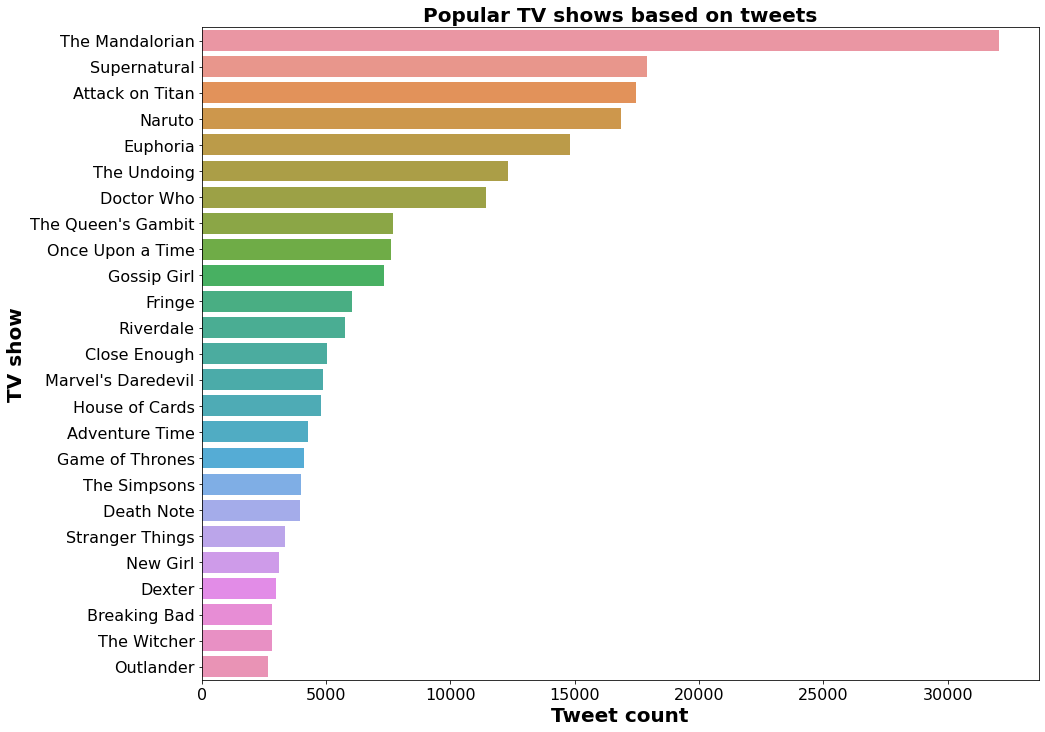

In [7]:
# Popular TV shows based on tweets (either hashtag or text)
tweet_count = spark.sql(""" SELECT name, tweet_count FROM tvshow
                            JOIN (SELECT id, SUM(tweet_count) AS tweet_count FROM tweet_stat GROUP BY id) tweet_count
                            ON tvshow.id = tweet_count.id
                            ORDER BY tweet_count DESC
                          """).toPandas()
# Bar plot
plt.figure(figsize=(15,12))
sns.barplot(x = 'tweet_count',
            y = 'name',
            data = tweet_count.loc[0:24, :])
plt.xlabel('Tweet count', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('TV show', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.title('Popular TV shows based on tweets', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Popular TV shows based on hashtags')

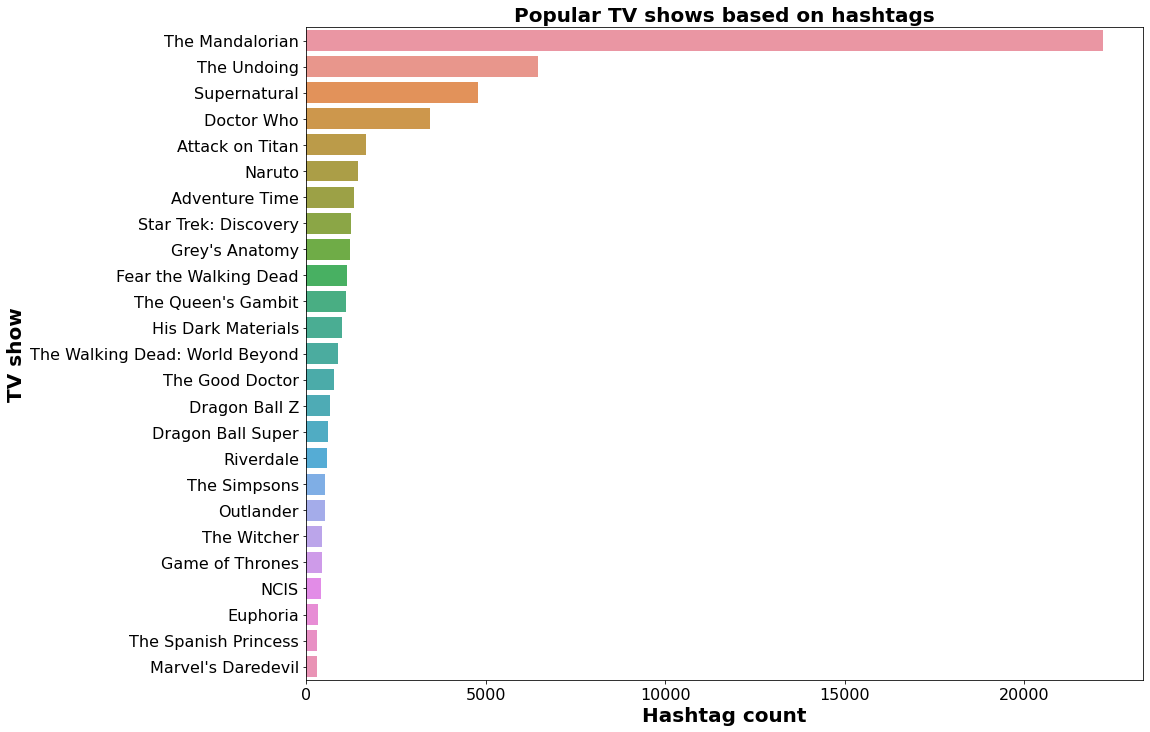

In [8]:
# Popular TV shows based on hashtags
hashtag_count = spark.sql(""" SELECT name, hashtag_count FROM tvshow
                              JOIN (SELECT id, SUM(hashtag_count) AS hashtag_count FROM tweet_stat GROUP BY id) hashtag_count
                              ON tvshow.id = hashtag_count.id
                              ORDER BY hashtag_count DESC
                          """).toPandas()
# Bar plot
plt.figure(figsize=(15,12))
sns.barplot(x = 'hashtag_count',
            y = 'name',
            data = hashtag_count.loc[0:24, :])
plt.xlabel('Hashtag count', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('TV show', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.title('Popular TV shows based on hashtags', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Popular TV shows based TMDB')

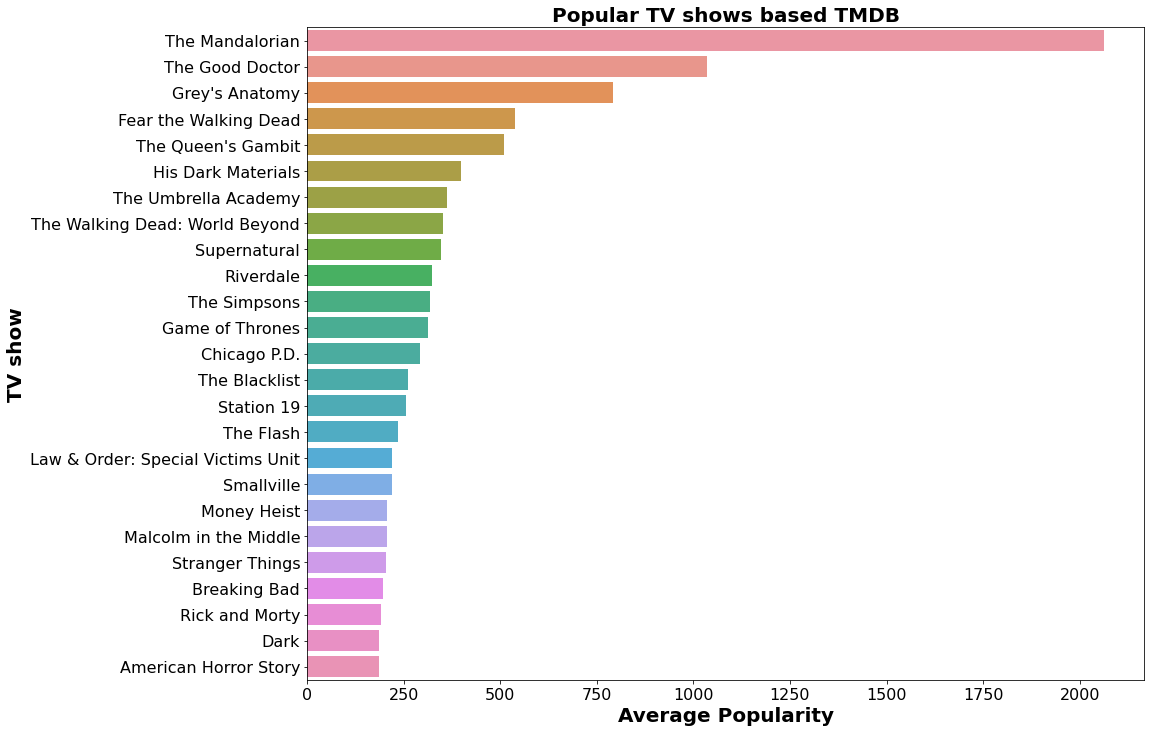

In [9]:
# Popular TV shows based on TMDB
tmdb_ave_popularity = spark.sql(""" SELECT name, ave_pop FROM tvshow
                                    JOIN (SELECT MEAN(popularity) AS ave_pop, id FROM tmdb_stat GROUP BY id) tmdb_pop
                                    ON tvshow.id = tmdb_pop.id
                                    ORDER BY ave_pop DESC
                                """).toPandas()
# Bar plot
plt.figure(figsize=(15,12))
sns.barplot(x = 'ave_pop',
            y = 'name',
            data = tmdb_ave_popularity.loc[0:24, :])
plt.xlabel('Average Popularity', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16)
plt.ylabel('TV show', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.title('Popular TV shows based TMDB', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Tweet counts per day')

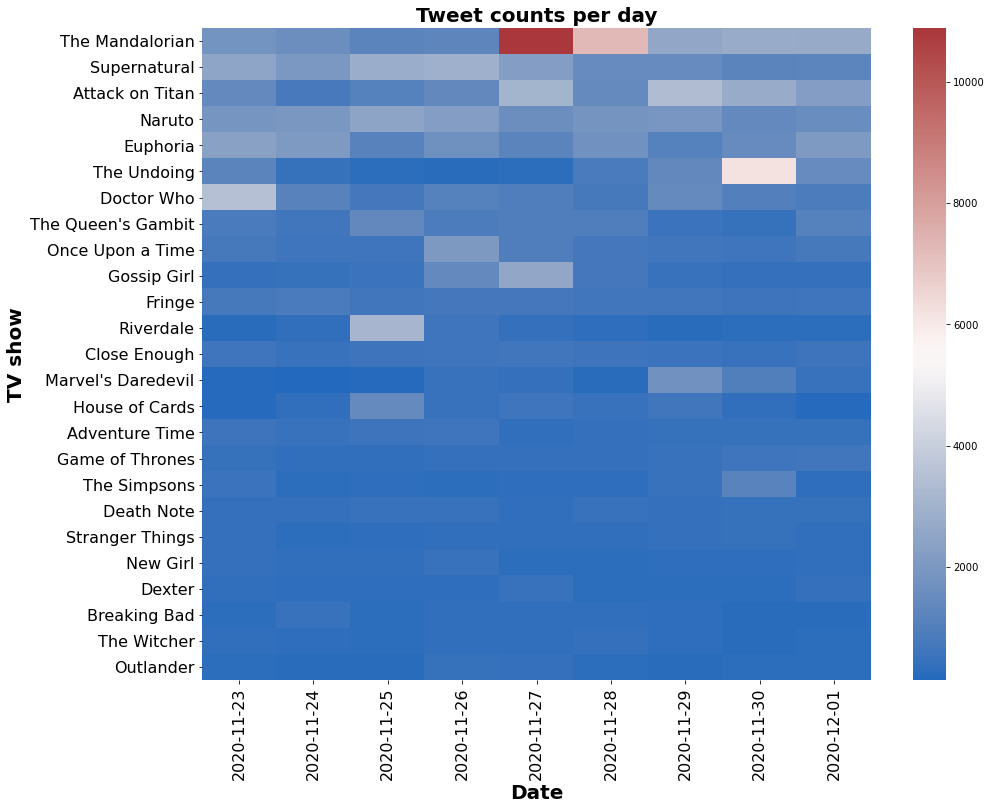

In [10]:
# Daily tweet counts of top 25 most popular TV shows based on tweets
tweet_count_daily = spark.sql(
    """
    SELECT tvshow.name, tweet_stat.tweet_count, tweet_stat.date FROM tvshow
    JOIN tweet_stat
    ON tvshow.id = tweet_stat.id
    JOIN (SELECT id, SUM(tweet_count) AS total_count FROM tweet_stat
          GROUP BY id ORDER BY total_count DESC LIMIT 25) tweet_count
    ON tvshow.id = tweet_count.id
    """).toPandas()

# Heat map
tweet_count_map = pd.pivot_table(tweet_count_daily, values='tweet_count', index=['name'], columns='date')
top_tv_show_names = tweet_count['name'].loc[0:24].tolist()
tweet_count_map = tweet_count_map.reindex(top_tv_show_names)

plt.figure(figsize=(15,12))
ax = sns.heatmap(tweet_count_map, cmap=sns.color_palette("vlag", as_cmap=True))
plt.xlabel('Date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, rotation=90)
plt.ylabel('TV show', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.title('Tweet counts per day', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'Hashtag counts per day')

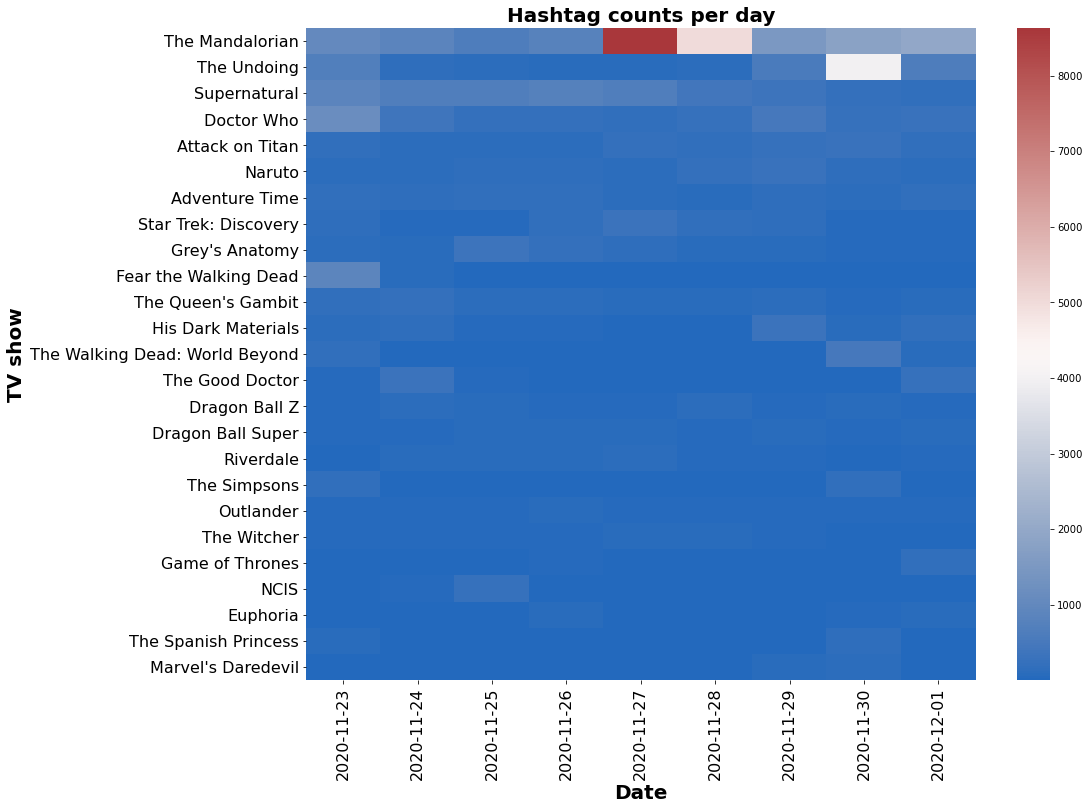

In [11]:
# Daily hashtag counts of top 25 most popular TV shows based on hashtags
hashtag_count_daily = spark.sql(
    """
    SELECT tvshow.name, tweet_stat.hashtag_count, tweet_stat.date FROM tvshow
    JOIN tweet_stat
    ON tvshow.id = tweet_stat.id
    JOIN (SELECT id, SUM(hashtag_count) AS total_count FROM tweet_stat
          GROUP BY id ORDER BY total_count DESC LIMIT 25) hashtag_count
    ON tvshow.id = hashtag_count.id
    """).toPandas()

# Heat map
hashtag_count_map = pd.pivot_table(hashtag_count_daily, values='hashtag_count', index=['name'], columns='date')
top_tv_show_names = hashtag_count['name'].loc[0:24].tolist()
hashtag_count_map = hashtag_count_map.reindex(top_tv_show_names)

plt.figure(figsize=(15,12))
ax = sns.heatmap(hashtag_count_map, cmap=sns.color_palette("vlag", as_cmap=True))
plt.xlabel('Date', fontsize=20, fontweight='bold')
plt.xticks(fontsize=16, rotation=90)
plt.ylabel('TV show', fontsize=20, fontweight='bold')
plt.yticks(fontsize=16)
plt.title('Hashtag counts per day', fontsize=20, fontweight='bold')